# Chapter 5 - Compressing Data via Dimensionality Reduction

An alternative approach to feature selection for dimensionality reduction is feature extraction. Three fundamental techniques are described that help summarize the infmroation contecnt of a dataset by transorming it into a new feature subspace of lower dimensionality than the original one.It helps store and analyze increasing amounts of data that are produced in the modern age of technology.

* Principal Component Analysis (PCA) for unsupervised data compression
* Linear Discriminant Analysis (LDA) as a supervised dimensionality reduction technique for maximizing class seperability
* Nonlinear dimensionality reduction via Kernel Principal Componant Analysis (KPCA)

## Unsupervised dimensionality reduction via PCA

Similar to feature selection, feature extraction techniques can reduce the number of features in a dataset. The difference is as follows; while feature selection maintains the original features, while feature extraction is used to transform or project the data onto a new feature space. It can be understood as an approach to data compression with the goal of maintaining most of the relevant information. It is not only used to improve storage space or computational efficiency, but can also enhance predictive performance by reducing the curse of dimensionality

PCA helsp to identify patterns in data based on correlation between features. PCA aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance given that the new axes are orthogonal to each other.

A result of transorming is that the first principal component will have the largest possible variance and the other components are uncorrelated to the other principal components. PCA directions are highly sensitive to data scaling and therefore standardizing is necessary befor PCA.

* 1) Standardize the d-dimensional dataset
* 2) Construct the covariance matrix
* 3) Decompose the covariance matrix into its eigenvectors and eigenvalues
* 4) Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors
* 5) Select k eigenvectors which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (k =< d)
* 6) Construct a projection matrix W from the 'top' k eigenvectors
* 7) Transform the d-dimensional input dataset X using the projectsino matrix W to obtain the new k-dimensional features subspace.

In [2]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3, 
                     stratify = y,
                    random_state = 0)


#### 1) Standardize the features

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

#### 2) Construct the covariance matrix

In [11]:
import numpy as np
cov_mat = np.cov(X_train_std.T)

#### 3) Decompose into eigenvalues and eigenvectors

In [12]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


#### 4) Sort the eigenvalues by decreasing order (and create a plot)

The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude, as we only select the subset of eigenvectors (principal components) which contain most of the information (variance).
We are interested in the top k eigenvectors based on the values of their corresponding values. 
Here follows a plot of the variance explained ratios of the eigenvalues (simply the ratio of an eigenvalue as a fracton of the total sum of eigenvalues)

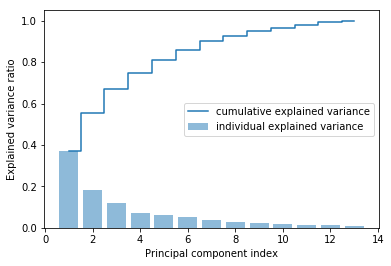

In [7]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha = 0.5, align = 'center',
       label = 'individual explained variance')
plt.step(range(1,14), cum_var_exp, where = 'mid',
        label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc = 'best')
plt.show()

The plot shows that the first principal component is responsible for almost 40 percent of the variance and the first two PC's togehter almost 60%.Remember that this is an unsupervised method and that class labels are ignored.

#### 5) Select k eigenvectors

We collect two eigenvectors that correspond to the two largest eigenvalues to capture about 60 percent of the variance. We only take two eigenvectors for purpose of illustration. Normally the number of PC's is a trade-off between computational efficiency and performance of the classifier

In [13]:
#Sorting eigenpairs

#Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

#sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key = lambda k: k[0], reverse = True)

#### 6) Construct a projection matrix W

In [20]:
#Select two eigenvectors
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
              
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


#### 7) Transform data into new k-dimensional feature space

In [28]:
#Matrixwise multiplication of standardized training data with projection matrix W
X_train_pca = X_train_std.dot(w)

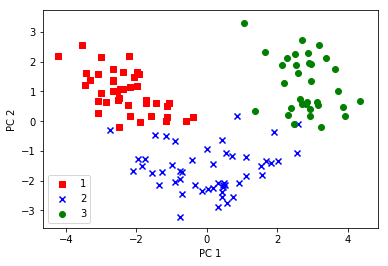

In [33]:
#Visualize the transofmred Wine training set
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train ==l, 0],
                X_train_pca[y_train ==l, 1],
                c = c, label = l, marker = m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

The data is more spread among the x-axis  (the first PC) than the y-axis (the second PC) which is consistent with the explained variance.

## PCA in scikitlearn

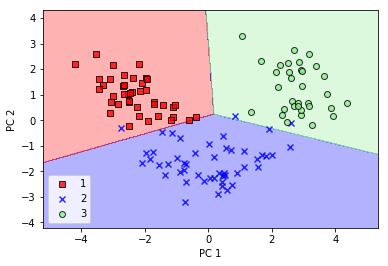

In [34]:
#Visualize the decision regions via plot_decision_regions

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution = 0.02):
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha = 0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = cl,
                    edgecolor = 'black')
        
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc ='lower left')
plt.show()

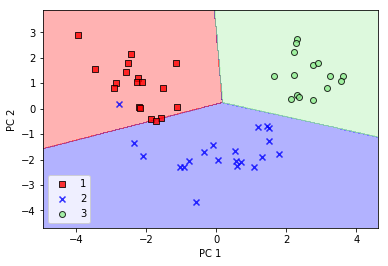

In [35]:
#Plot decision regions of the LR on transformed test dataset
plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

If we are interested in explained variance ratios, we can also use sklearn with the n_components set to None. It will return all PC's in a sorted order instead of performing dimensionality reduction

In [36]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

## Supervised data compression via linear discriminant analysis

LDA can be used as a thcnique for feature extraction to increase the computational efficiency and reduce the degree of overfitting due to the curse of dimensionality in non-regularized models. Very similar to PCA, although where PCA attemps to find the orthogonal components with the maximum variance, LDA is to find the feature subspace that optimizes class seperability.

LDA has the assumption that the data is normally distributed, that the classes have identical covariance matrices and that the samples are statistically independent of each other (although LDA can still work reasonably well if one of the assumptions is violated).

Steps
* 1) Standardize the d-dimensional dataset (d = number of features)
* 2) For each class, compute the d-dimensional mean vector
* 3) Construct the between-class scatter matrix Sb and the within-class scatter matrix Sw
* 4) Compute the eigenvectors and corresponding eigenvalues of the matrix Sw-1Sb
* 5) Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors
* 6) Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d*k-dimensional transformation matrix W; the eigenvectors are the columns of this matrix
* 7) Project the samples onto the new feature subspace using the transformation matrix W

#### 2) Compute the mean vectors

For each class (in the target variable) the mean of each feature is calculated

In [40]:
np.set_printoptions(precision = 4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis = 0))

    print('MV %s:  %s\n' %(label, mean_vecs[label-1]))

MV 1:  [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2:  [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3:  [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



#### 3) Compute the between and within cclass scatter matrices

Within-class scatter matrix can be calculate by summing up the individual scatter matrices Si of each class.
Si = sum(x-mi)(x-mi)T
For the within-class scatter matrix it is important that the class labels are uniformely distributed (which is not often the case). Therefore per class the matrices should be divided by the number of samples, this is mathematically identical to calculating the coveriance matrix.



In [44]:
#within class scatter matrix without correcting for not uniform distribution of classes
d = 13
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [45]:
print('Class label distribution: %s' %np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [47]:
#Covariance matrix
d = 13 # number of features
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [83]:
#Between class scatter matrix
mean_overall = np.mean(X_train_std, axis = 0)
d = 13
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d,1) #make columns vector
    mean_overall = mean_overall.reshape(d,1)
    S_B += n * (mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


#### 4) Compute eigenvalues

In [84]:
eigen_vals, eigen_vecs =\
np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

#### 5) Sort eigenvalues

In [85]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,
                    key =lambda k: k[0], reverse = True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059941
172.76152218979396
2.842170943040401e-14
2.802918371273055e-14
2.802918371273055e-14
2.3211531779995518e-14
1.7107806523921705e-14
1.362141116648383e-14
1.362141116648383e-14
1.2159776532470691e-14
6.675739583062694e-15
3.5512596148824626e-15
3.5512596148824626e-15


#### 6) Select eigenvectors

In LDA the number of linear discriminants is at most c-1 (where c is the number of class labels), since the in-between scatter matrix is the sum of c matrices with rank 1 or less. We can see that we only have two nonzero eigenvalues

We can calculate how much of the class-discrimnatory information is captured by the linear discriminants (eigenvectors)

<function matplotlib.pyplot.show(*args, **kw)>

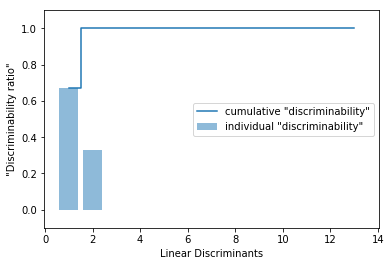

In [86]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14), discr, alpha = 0.5, align = 'center',
       label = 'individual "discriminability"')
plt.step(range(1,14), cum_discr, where = 'mid',
        label = 'cumulative "discriminability"')
plt.ylabel('"Discriminability ratio"')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc ='best')
plt.show

In [87]:
#Construct transformation matrix W
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


#### 7) Project samples on new feature subspace

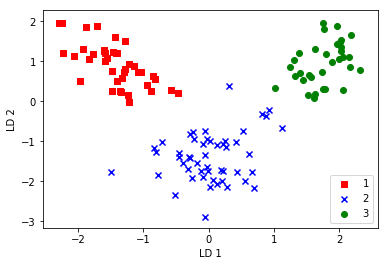

In [88]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
               X_train_lda[y_train == l, 1] * -1,
               c = c, label = l, marker =m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower right')
plt.show()

## LDA via scikit-learn

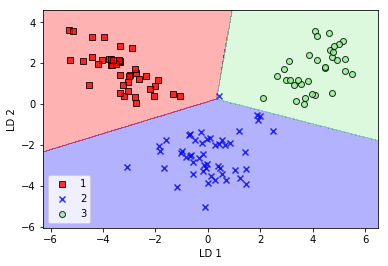

In [89]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.show()

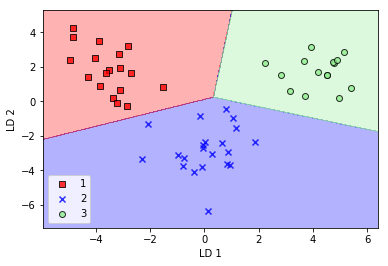

In [91]:
#Test set
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.show()

## Kernel PCA for nonlinear mappings

In dealing with nonlinear problems (which are prevalent in real-world applications) PCA and LDA may not be the best choice (as these algorithms assume that the data is linearly separable)

The kernelized version of PCA (KPCA) may then be beneficial. Using KPCA we can transform data that is not linearly seperable onto a new, lower dimensional subspace that is suitable for linear classifiers.

In KPCA the samples are already projected onto respective components, rather than constructing a transformation matrix as in standard PCA approach. Basically, the kernel function (or simply kernel) can be understood as a function that calculates a dot product between two fectors - a measure of similarity.

The most commonly used kernels are; the polynomial kernel, hyperbolic tangent (sigmoid) kernel, Radial Basis Function (RBF) also called Gaussian kernel.

We can define three steps to implement an RBF kernel PCA

* 1) Compute the kernel (similarity) matrix K (exp(-y || x(i) - x(i)|| ^2)) where y is 1/2o. Do this for each pair of samples; if a dataset contains 100 training examples, the kernel matrix of the pairwise similarities would be 100x100
* 2) Center the kernel matrix K
* 3) Collect the top k eigenvectors of tehe centered kernel matrix, based on their eigenvalues, which are ranked b decreasing magnitued.

In [104]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation
    
    Parameters
    -----------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    
    gamma: float
      Tuning parameters of the RBF kernel
      
    n_components: int
      Number of principal components to return
      
    Returns
    ---------
    X_pc: {NumPy array}, shape = [n_samples, k_features]
      Projected dataset
    
    """
    #Calculate pairwise squared Euclidean distances
    #in the MXN dimensional dataset
    sq_dists = pdist(X, 'sqeuclidean')
    
    #Convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists)
    
    #Compute the symmetric kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    #Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    #Obtaining eigenpairs from the centered kernel matrix
    #scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    #Collect top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:,i] for i in range(n_components)))
    
    return X_pc

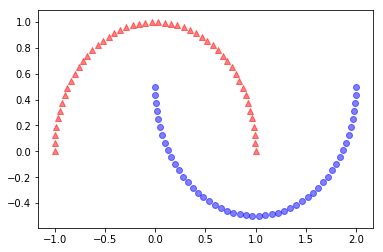

In [105]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 100, random_state = 123)
plt.scatter(X[y==0,0], X[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(X[y==1,0], X[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)
plt.show()

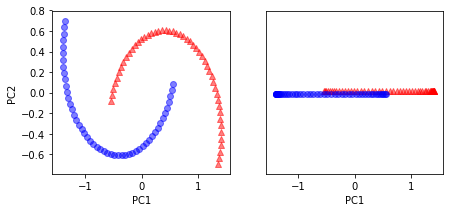

In [108]:
#Standard PCA
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components =2 )
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7,3))
ax[0].scatter(X_spca[y==0,0], X_spca[y==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_spca[y==1,0], X_spca[y==1, 1], color = 'blue', marker = 'o', alpha = 0.5)
ax[1].scatter(X_spca[y==0,0], np.zeros((50,1))+0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_spca[y==1,0], np.zeros((50,1))-0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

As seen from the plot above, standard PCA is not able to separate the different classes

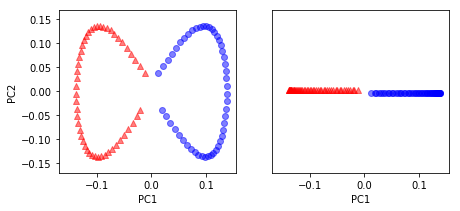

In [113]:
X_kpca = rbf_kernel_pca(X, gamma = 15, n_components = 2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7,3))
ax[0].scatter(X_kpca[y==0,0], X_kpca[y==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_kpca[y==1,0], X_kpca[y==1, 1], color = 'blue', marker = 'o', alpha = 0.5)
ax[1].scatter(X_kpca[y==0,0], np.zeros((50,1))+0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_kpca[y==1,0], np.zeros((50,1))-0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

As can be seen from the plot above the kernel pca now creates a linearly seperatable problem. Altough finding the good value for gamma is challenging and requires experimentation

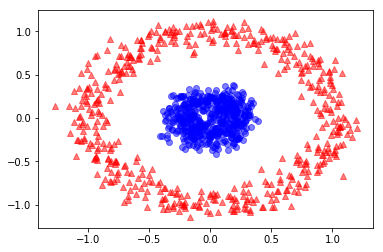

In [115]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples = 1000, 
                   random_state = 123, noise = 0.1, factor = 0.2)
plt.scatter(X[y==0,0], X[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(X[y==1,0], X[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)
plt.show()

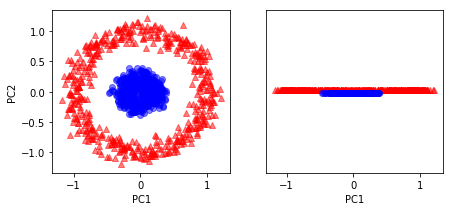

In [117]:
#standard PCA
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components =2 )
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7,3))
ax[0].scatter(X_spca[y==0,0], X_spca[y==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_spca[y==1,0], X_spca[y==1, 1], color = 'blue', marker = 'o', alpha = 0.5)
ax[1].scatter(X_spca[y==0,0], np.zeros((500,1))+0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_spca[y==1,0], np.zeros((500,1))-0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

Standard PCA is not able to linearly seperate the datapoints

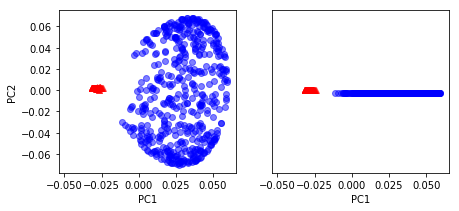

In [118]:
#Kernel PCA
X_kpca = rbf_kernel_pca(X, gamma = 15, n_components = 2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (7,3))
ax[0].scatter(X_kpca[y==0,0], X_kpca[y==0, 1], color = 'red', marker = '^', alpha = 0.5)
ax[0].scatter(X_kpca[y==1,0], X_kpca[y==1, 1], color = 'blue', marker = 'o', alpha = 0.5)
ax[1].scatter(X_kpca[y==0,0], np.zeros((500,1))+0.02, color = 'red', marker = '^', alpha = 0.5)
ax[1].scatter(X_kpca[y==1,0], np.zeros((500,1))-0.02, color = 'blue', marker = 'o', alpha = 0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1,1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

Better with Kernel PCA. If we have a training and test set, we can use kernel PCA to convert the test-set as well. We have to re-use the oriiginal trainign set each time to project new(test) samples.We have to calculate the pairwise RBF kernel between each ith sample in the training dataset and the new sample. Therefore we need the eigenvalues of the kernel matrix and therefore we will adjust the KPCA function.

In [138]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation
    
    Parameters
    -----------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    
    gamma: float
      Tuning parameters of the RBF kernel
      
    n_components: int
      Number of principal components to return
      
    Returns
    ---------
    aplhas {NumPy array}, shape = [n_samples, k_features]
      Projected dataset
    
    lambdas: list
      Eigenvalues
    
    """
    #Calculate pairwise squared Euclidean distances
    #in the MXN dimensional dataset
    sq_dists = pdist(X, 'sqeuclidean')
    
    #Convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists)
    
    #Compute the symmetric kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    #Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    #Obtaining eigenpairs from the centered kernel matrix
    #scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    #Collect top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:,i] for i in range(n_components)))
    
    #Collect corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas

In [148]:
X, y = make_moons(n_samples = 100, random_state = 123)
alphas, lambdas = rbf_kernel_pca(X, gamma = 15, n_components = 1)

In [149]:
#Project 26th point of X on the new subspace
x_new = X[25]
x_proj = alphas[25]
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k  = np.exp(-gamma * pair_dist)
    return k.dot(alphas/lambdas)

In [150]:
x_reproj = project_x(x_new, X, gamma = 15, alphas = alphas, lambdas = lambdas)

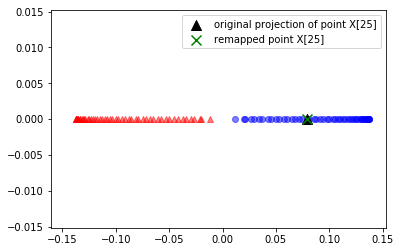

In [151]:
plt.scatter(alphas[y==0, 0], np.zeros((50)), color = 'red', marker = '^', alpha = 0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color = 'blue', marker = 'o', alpha = 0.5)
plt.scatter(x_proj, 0, color = 'black', label = 'original projection of point X[25]', marker = '^', s = 100)
plt.scatter(x_reproj, 0, color = 'green', label = 'remapped point X[25]', marker = 'x', s = 100)
plt.legend(scatterpoints = 1)
plt.show()

## KPCA in scikit-learn

In [152]:
from sklearn.decomposition import KernelPCA
X, y = make_moons(n_samples = 100, random_state = 123)
scikit_kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_skernpca = scikit_kpca.fit_transform(X)

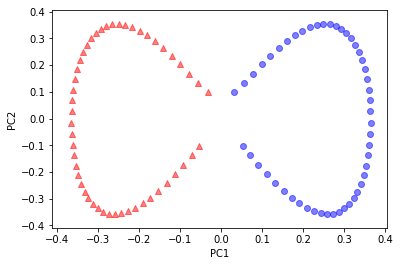

In [154]:
plt.scatter(X_skernpca[y==0,0], X_skernpca[y==0,1], color = 'red', marker = '^', alpha = 0.5)
plt.scatter(X_skernpca[y==1,0], X_skernpca[y==1,1], color = 'blue', marker = 'o', alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()